In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Hyperparameters
learning_rate = 0.001
batch_size = 64
num_epochs = 10

In [4]:
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Define the victim model (Simple Feedforward Neural Network)
class VictimModel(nn.Module):
    def __init__(self):
        super(VictimModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1) # output is 26x26x32
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1) # output is 24x24x64
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.fc1 = nn.Linear(in_features=9216, out_features=128) # in_features = 24*24*64*0.25
        self.dropout2 = nn.Dropout2d(p=0.5)
        self.fc2 = nn.Linear(in_features=128, out_features=10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        
        return output

In [6]:
# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    train_acc_list = []

    for epoch in range(num_epochs):
        correct, total, running_loss = 0, 0, 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Ensure images are in correct shape (batch_size, 1, 28, 28)
            images = images.view(-1, 1, 28, 28)  

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Accuracy calculation
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
        
        train_acc = correct / total
        train_acc_list.append(train_acc)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_acc:.4f}')

    return train_acc_list


# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():  # No gradients needed during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Ensure images are in correct shape (batch_size, 1, 28, 28)
            images = images.view(-1, 1, 28, 28)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = correct / total
    print(f'Test Accuracy: {test_acc:.4f}')
    return test_acc

In [7]:
# Initialize model, loss function, and optimizer
model = VictimModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train and evaluate
train_acc_list = train_model(model, train_loader, criterion, optimizer, num_epochs)
test_acc = evaluate_model(model, test_loader)

print(f'Final Test Accuracy: {test_acc:.4f}')

/home/trial/Desktop/fgma attack/fgsm-attack/myenv/lib/python3.12/site-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch [1/10], Loss: 0.2173, Train Accuracy: 0.9340
Epoch [2/10], Loss: 0.0870, Train Accuracy: 0.9739
Epoch [3/10], Loss: 0.0671, Train Accuracy: 0.9796
Epoch [4/10], Loss: 0.0532, Train Accuracy: 0.9835
Epoch [5/10], Loss: 0.0496, Train Accuracy: 0.9841
Epoch [6/10], Loss: 0.0424, Train Accuracy: 0.9871
Epoch [7/10], Loss: 0.0387, Train Accuracy: 0.9878
Epoch [8/10], Loss: 0.0343, Train Accuracy: 0.9889
Epoch [9/10], Loss: 0.0325, Train Accuracy: 0.9896
Epoch [10/10], Loss: 0.0275, Train Accuracy: 0.9912
Test Accuracy: 0.9914
Final Test Accuracy: 0.9914


In [8]:
# FGSM attack
class FGSMAttack(object):
    def __init__(self, model, epsilons, test_dataloader, device, target=None):
        self.model = model
        self.epsilons = epsilons
        self.test_dataloader = test_dataloader
        self.device = device
        self.target = target
        self.adv_examples = {}
        
    def perturb(self, x, eps, grad):
        x_prime = None
        if self.target:
            x_prime = x - eps * grad.sign()
        else:
            x_prime = x + eps * grad.sign()
            
        # keep image data in the [0,1] range
        x_prime = torch.clamp(x_prime, 0, 1)
        return x_prime
    
    def run(self):
        # run the attack for each epsilon
        for epsReal in self.epsilons:
            self.adv_examples[epsReal] = [] # store some adv samples for visualization
            eps = epsReal - 1e-7 # small constant to offset floating-point errors
            successful_attacks = 0

            for data, label in self.test_dataloader:
                # send dat to device
                data, label = data.to(self.device), label.to(self.device)
                
                # FGSM attack requires gradients w.r.t. the data
                data.requires_grad = True
                
                output = self.model(data)
                init_pred = output.argmax(dim=1, keepdim=True)
                if init_pred.item() != label.item():
                    # image is not correctly predicted to begin with, skip
                    continue
                if self.target and self.target == label.item():
                    # if the image has the target class, skip
                    continue
                    
                # calculate the loss
                L = nn.CrossEntropyLoss()
                loss = None
                if self.target:
                    # in a target attack, we take the loss w.r.t. the target label
                    loss = L(output, torch.tensor([self.target], dtype=torch.long))
                else:
                    loss = L(output, torch.tensor([init_pred.item()], dtype=torch.long))
                
                # zero out all existing gradients
                self.model.zero_grad()
                # calculate gradients
                loss.backward()
                data_grad = data.grad
                
                perturbed_data = self.perturb(data, eps, data_grad)
                
                # predict class for adversarial sample
                adv_output = self.model(perturbed_data)
                adv_pred = adv_output.argmax(dim=1, keepdim=True)
                
                if self.target:
                    if adv_pred.item() == self.target:
                        successful_attacks += 1
                        if len(self.adv_examples[epsReal]) < 5:
                            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                            self.adv_examples[epsReal].append( (init_pred.item(), adv_pred.item(), adv_ex ) )       
                else:
                    if adv_pred.item() != init_pred.item():
                        successful_attacks += 1
                        if len(self.adv_examples[epsReal]) < 5:
                            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                            self.adv_examples[epsReal].append( (init_pred.item(), adv_pred.item(), adv_ex ) )
                
            # print status line
            success_rate = successful_attacks / float(len(self.test_dataloader))
            print("Epsilon: {}\tAttack Success Rate = {} / {} = {}".format(epsReal, successful_attacks, len(self.test_dataloader), success_rate))
            
    def visualize(self):
        plt.figure(figsize=(8,10))
        cnt = 0
        for eps, adv_examples in self.adv_examples.items():
            for index, data in enumerate(adv_examples):
                cnt += 1
                plt.subplot(len(self.adv_examples.keys()), len(adv_examples), cnt)
                plt.xticks([], [])
                plt.yticks([], [])
                if index == 0:
                    plt.ylabel("Eps: {}".format(eps), fontsize=14)
                
                orig, adv, adv_ex = data
                plt.title("{} -> {}".format(orig, adv))
                plt.imshow(adv_ex, cmap="gray")
            # round cnt up to next multiple of 5
            cnt += 4
            cnt -= cnt % 5
        plt.tight_layout()
        if self.target:
            plt.savefig("data/img/t{}_fgsm.png".format(self.target))
        else:
            plt.savefig("data/img/ut_fgsm.png")
        plt.show()

In [13]:
epsilons = [0.1, 0.15, 0.2, 0.25, 0.3]
model.eval()
# MNIST Test dataset and dataloader declaration
t = transforms.Compose([
            transforms.ToTensor(),
            ])
subsampler = torch.utils.data.SubsetRandomSampler(range(100))
test_dataloader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=t),
    batch_size=1, sampler=subsampler)

target = 8
fgsm_attack = FGSMAttack(model, epsilons, test_dataloader, device, target)
fgsm_attack.run()

[W225 23:48:07.647365108 NNPACK.cpp:62] Could not initialize NNPACK! Reason: Unsupported hardware.


Epsilon: 0.1	Attack Success Rate = 44 / 100 = 0.44
Epsilon: 0.15	Attack Success Rate = 66 / 100 = 0.66
Epsilon: 0.2	Attack Success Rate = 75 / 100 = 0.75
Epsilon: 0.25	Attack Success Rate = 76 / 100 = 0.76
Epsilon: 0.3	Attack Success Rate = 78 / 100 = 0.78


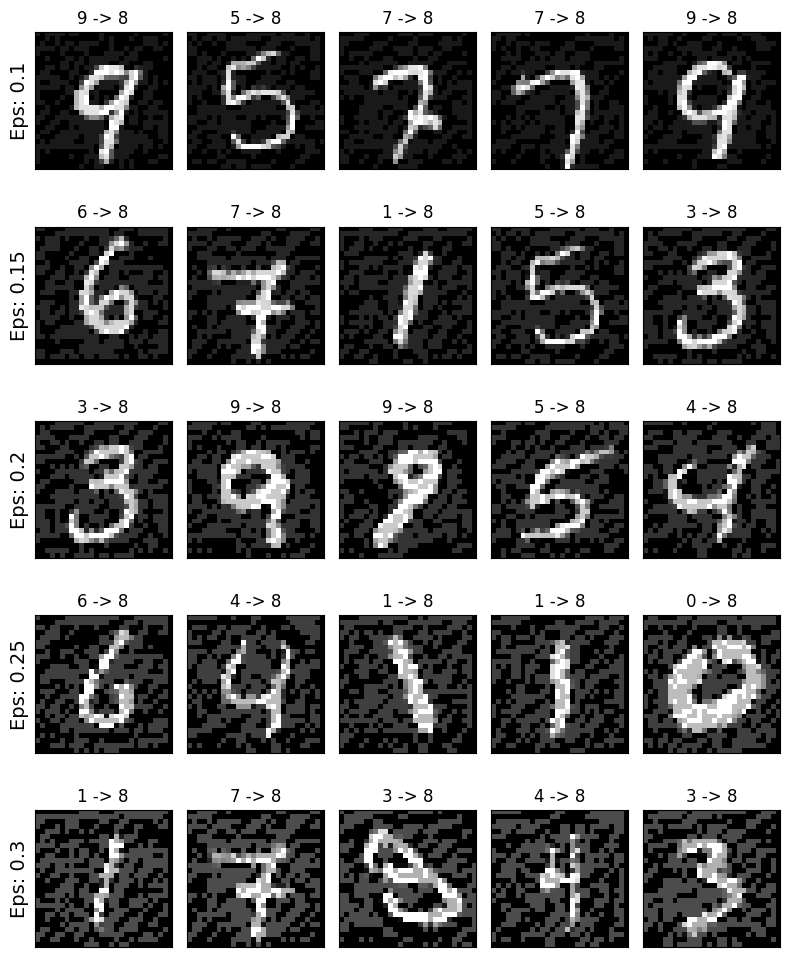

In [14]:
fgsm_attack.visualize()